# Lecture 18 - Contrastive Learning 

```{contents}
:local:
:depth: 1
```

**Learning goals**

- Understand the idea of **contrastive learning**.
- Construct **positive pairs** and **negative pairs** using easy augmentations that mimic lab variability.
- Write and inspect a **InfoNCE loss** with small arrays before touching any model.
- Practice designing **augmentations** for spectra and reaction conditions.


[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1EJqZIdStTwhshi348NqQyYiuX-WVBdP5?usp=sharing)     

## 1. Setup

In [1]:
# 1. Setup
import os, math, sys, textwrap, random, pathlib, json, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional scientific extras
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception:
    torch = None

# Optional chemistry toolkit
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, auc
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(18)

# Plot defaults
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["axes.grid"] = True

def show_shape(name, x):
    if hasattr(x, "shape"):
        print(f"{name}.shape:", x.shape)
    else:
        print(f"{name}: (no .shape) type={type(x)}")

def head(arr, n=3, name="arr"):
    print(f"{name} head:")
    print(np.asarray(arr)[:n])

---

## 2. Contrastive learning concepts

Why contrastive learning?
In many lab projects, positive results are rare and negatives are mixed with non-attempts.  
Contrastive learning can pretrain an embedding using instance agreement without needing full labels, then a small labeled set can train a light classifier on top.

The basic objective is simple: samples that are **different views of the same underlying item** should be **close** in the embedding, while **different items** should be **far**.

- A view can be a small transformation that preserves identity.  
- In chemistry we can mimic instrument noise, baseline drift, slight temperature jitter, or solvent variations that do not change the label of interest.

We will keep the math light and the code step-by-step.

### 2.1 What is a positive pair and a negative pair

- **Positive pair**: two views of the same experiment or the same molecule.  
- **Negative pair**: two views that come from different experiments or different molecules.

Example labels for a toy case:
- An experiment that yields the product with high purity.  
- Two instruments that read the same sample but with slight noise.  
These two readings form a **positive pair**. Two readings from different samples form a **negative pair**.

### 2.2 Cosine similarity

Cosine similarity measures the angle between vectors. It is large when vectors point in the same direction.

$
\operatorname{cos\_sim}(u,v)=\frac{u\cdot v}{\|u\|\,\|v\|}
$

We use it because the magnitude is not as important as the direction in many embedding spaces.

In [2]:
# Cosine similarity in NumPy
def cos_sim(u, v, eps=1e-8):
    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)
    num = np.dot(u, v)
    den = np.linalg.norm(u) * np.linalg.norm(v) + eps
    return float(num / den)

a = np.array([1.0, 0.0])
b = np.array([0.8, 0.2])
c = np.array([-1.0, 0.0])

print("cos(a,b) =", cos_sim(a,b))
print("cos(a,c) =", cos_sim(a,c))

cos(a,b) = 0.970142488380626
cos(a,c) = -0.9999999900000002


Below is the verctor visualization. You can see a b are similar to each other which a c are very different (opposite).

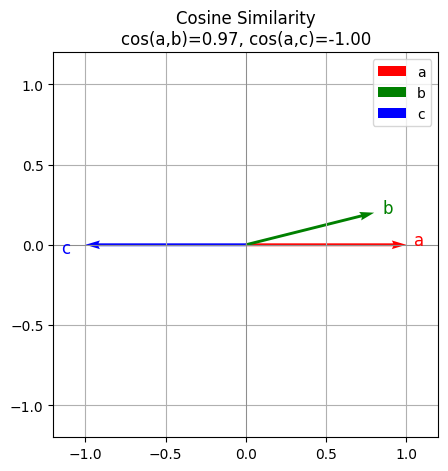

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define cosine similarity
def cos_sim(u, v, eps=1e-8):
    u = np.asarray(u, dtype=float)
    v = np.asarray(v, dtype=float)
    num = np.dot(u, v)
    den = np.linalg.norm(u) * np.linalg.norm(v) + eps
    return float(num / den)

# Example vectors
a = np.array([1.0, 0.0])
b = np.array([0.8, 0.2])
c = np.array([-1.0, 0.0])

# Compute cosine similarities
cos_ab = cos_sim(a, b)
cos_ac = cos_sim(a, c)

# Plot vectors
origin = np.zeros(2)
plt.figure(figsize=(5, 5))
plt.quiver(*origin, *a, angles='xy', scale_units='xy', scale=1, color='r', label='a')
plt.quiver(*origin, *b, angles='xy', scale_units='xy', scale=1, color='g', label='b')
plt.quiver(*origin, *c, angles='xy', scale_units='xy', scale=1, color='b', label='c')

# Annotate vectors and angles
plt.text(a[0]+0.05, a[1], 'a', color='r', fontsize=12)
plt.text(b[0]+0.05, b[1], 'b', color='g', fontsize=12)
plt.text(c[0]-0.15, c[1]-0.05, 'c', color='b', fontsize=12)

# Annotate cosine similarity
plt.title(f"Cosine Similarity\ncos(a,b)={cos_ab:.2f}, cos(a,c)={cos_ac:.2f}")
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend()
plt.show()

---

## 3. Contrastive learning in chemistry

We simulate two experiment classes.  
Think of them as two reaction regimes.  
Each point is a pair of features:
- $x_0$ behaves like a normalized temperature.  
- $x_1$ behaves like a solvent family flag that you can think of as 0 or 1 with small jitter for plotting.

In [4]:
# 2D toy dataset with two regimes
n_pos = 120
n_neg = 120

x_pos = np.column_stack([
    rng.normal(0.70, 0.08, n_pos),
    np.clip(rng.normal(0.95, 0.05, n_pos), 0.0, 1.0)
])

x_neg = np.column_stack([
    rng.normal(0.40, 0.10, n_neg),
    np.clip(rng.normal(0.10, 0.06, n_neg), 0.0, 1.0)
])

X = np.vstack([x_pos, x_neg]).astype(np.float32)
y = np.hstack([np.ones(n_pos, dtype=int), np.zeros(n_neg, dtype=int)])

show_shape("X", X)
head(X, name="X")

X.shape: (240, 2)
X head:
[[0.6654 0.9177]
 [0.6096 0.9834]
 [0.7539 0.981 ]]


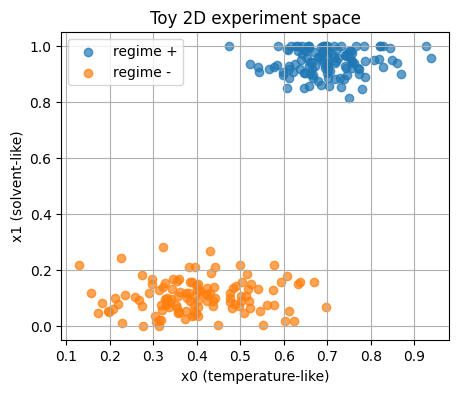

In [5]:
# Plot the two groups
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], alpha=0.7, label="regime +")
plt.scatter(X[y==0,0], X[y==0,1], alpha=0.7, label="regime -")
plt.xlabel("x0 (temperature-like)")
plt.ylabel("x1 (solvent-like)")
plt.title("Toy 2D experiment space")
plt.legend()
plt.show()

### 3.2 Simple train and test split

We keep a fixed split for repeatability.

Train size: 180  Test size: 60


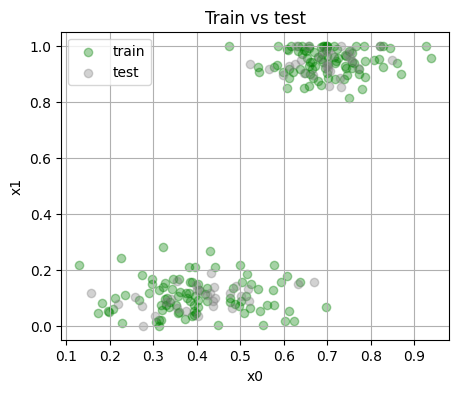

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=18, stratify=y
)
print("Train size:", len(X_train), " Test size:", len(X_test))
# Visualize the split
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], alpha=0.35, color = "green", label="train")
plt.scatter(X_test[:,0],  X_test[:,1],  alpha=0.35, color = "grey",  label="test")
plt.xlabel("x0")
plt.ylabel("x1")
plt.title("Train vs test")
plt.legend()
plt.show()

Now, let's keep the spirit of the 2D toy example but uses chemistry units.

- Feature 1: temperature `T_C` in the range 25 to 150 °C.  
- Feature 2: reaction concentration `conc_M` in molar units.

We form two regimes for a toy yield label.

In [7]:
# Chemistry-calibrated 2D dataset
n_pos2 = 350
n_neg2 = 350

T_pos = np.clip(rng.normal(110.0, 12.0, n_pos2), 25, 150)
C_pos = np.clip(rng.normal(0.60, 0.08, n_pos2), 0.05, 1.20)

T_neg = np.clip(rng.normal(55.0, 12.0, n_neg2), 25, 150)
C_neg = np.clip(rng.normal(0.25, 0.07, n_neg2), 0.05, 1.20)

X_chem2d = np.vstack([
    np.column_stack([T_pos, C_pos]),
    np.column_stack([T_neg, C_neg])
]).astype(np.float32)

y_chem2d = np.hstack([
    np.ones(n_pos2, dtype=int),
    np.zeros(n_neg2, dtype=int)
])

chem2d_df = pd.DataFrame({"T_C": X_chem2d[:,0], "conc_M": X_chem2d[:,1], "label": y_chem2d})
show_shape("X_chem2d", X_chem2d)
chem2d_df.head()

X_chem2d.shape: (700, 2)


,T_C,conc_M,label
0,93.191246,0.554962,1
1,98.001747,0.535892,1
2,106.118027,0.533380,1
3,86.066620,0.708883,1
4,85.482567,0.513050,1


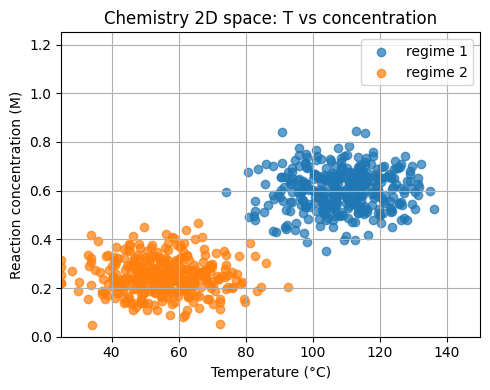

In [8]:
# Scatter of chemistry 2D with limits
plt.figure()
plt.scatter(chem2d_df.loc[y_chem2d==1, "T_C"], chem2d_df.loc[y_chem2d==1, "conc_M"], alpha=0.7, label="regime 1")
plt.scatter(chem2d_df.loc[y_chem2d==0, "T_C"], chem2d_df.loc[y_chem2d==0, "conc_M"], alpha=0.7, label="regime 2")
plt.xlim(25, 150)
plt.ylim(0.0, 1.25)
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction concentration (M)")
plt.title("Chemistry 2D space: T vs concentration")
plt.legend()
plt.tight_layout()
plt.show()

### 3.4 Add current and time

We extend the features to `[T_C, conc_M, current_mA, time_h]` and synthesize a label that is more graded.

In [9]:
# 4D chemistry dataset
N = 1500
T = rng.uniform(25, 150, N)
conc = rng.uniform(0.05, 1.20, N)
current = rng.uniform(10, 200, N)  # mA
# Times centered near 2.5 h with mild skew
log_time = rng.normal(math.log(2.5), 0.35, N)
time_h = np.clip(np.exp(log_time), 0.2, 8.0)

# Score that favors mid-high temperature, mid concentration, moderate time and current
score = (
    0.030*(T - 95.0) +
    2.0*(conc - 0.55) +
    0.40*np.log(time_h/2.0) +
    0.010*(current - 120.0)
)

# Add small noise
score += rng.normal(0.0, 0.35, N)

# Prob and label
prob = 1/(1+np.exp(-score))
label = (prob > 0.55).astype(int)

X_chem4d = np.column_stack([T, conc, current, time_h]).astype(np.float32)
chem4d_df = pd.DataFrame(
    {
        "T_C": T, "conc_M": conc, "current_mA": current, "time_h": time_h,
        "score": score, "prob": prob, "label": label
    }
)

show_shape("X_chem4d", X_chem4d)
chem4d_df

X_chem4d.shape: (1500, 4)


,T_C,conc_M,current_mA,time_h,score,prob,label
0,49.805883,0.600655,40.833851,2.157691,-2.208944,0.098950,0
1,126.562416,0.211544,72.354625,2.702346,-0.678296,0.336642,0
2,82.568180,0.127770,152.062647,3.505866,-0.606200,0.352927,0
3,48.536913,1.035117,30.949824,2.568091,-1.294756,0.215049,0
4,49.894593,0.263611,50.120879,4.105867,-2.681535,0.064072,0
...,...,...,...,...,...,...,...
1495,65.210976,1.024820,45.167810,1.961686,0.079109,0.519767,0
1496,106.716612,0.277887,57.055591,3.015707,-0.769024,0.316690,0
1497,58.082437,0.125463,19.037200,4.255520,-2.833547,0.055538,0
1498,100.070791,0.840978,105.132453,2.283671,0.285704,0.570944,1


As you can see here (and we have been seen similar cases many times this semester), when we go into high dimensional space with more and more reaction parameters, classification become challenging. In the previous lectures, we have many molecular descriptors, and now we have too many reaction parameters.

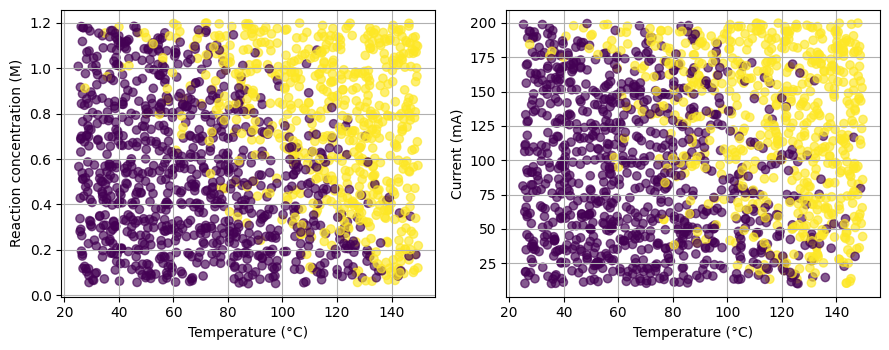

In [10]:
# Pairwise quick looks: T vs conc and T vs current
fig, axs = plt.subplots(1, 2, figsize=(9, 3.6))
sc0 = axs[0].scatter(chem4d_df["T_C"], chem4d_df["conc_M"], c=chem4d_df["label"], alpha=0.65)
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Reaction concentration (M)")
sc1 = axs[1].scatter(chem4d_df["T_C"], chem4d_df["current_mA"], c=chem4d_df["label"], alpha=0.65)
axs[1].set_xlabel("Temperature (°C)")
axs[1].set_ylabel("Current (mA)")
plt.tight_layout()
plt.show()

---

## 4. Building positive and negative pairs with easy augmentations

Contrastive learning needs pairs.  
We will define augmentations that keep the identity of the same sample.  
These are small changes that simulate instrument noise or small condition jitter.

### 4.1 Augmentations for the toy 2D data

In [11]:
def jitter(x, noise_std=0.02):
    x = np.asarray(x, dtype=float)
    return x + rng.normal(0.0, noise_std, size=x.shape)

def small_rotation(x, angle_std_deg=8.0):
    # Rotate 2D point around origin by a small random angle in degrees
    theta = np.deg2rad(rng.normal(0.0, angle_std_deg))
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return (R @ x.reshape(2,1)).ravel()

def clip01(x):
    return np.clip(x, 0.0, 1.0)

def augment_view(x):
    # One simple pipeline: jitter then a tiny rotation, then clip to [0,1]
    return clip01(small_rotation(jitter(x, 0.02), 6.0))

  # Show one point and two views
x0 = X_train[0]
v1 = augment_view(x0)
v2 = augment_view(x0)

print("Original:", x0)
print("View A   :", v1)
print("View B   :", v2)

Original: [0.6845 0.8594]
View A   : [0.4622 0.9731]
View B   : [0.8054 0.773 ]


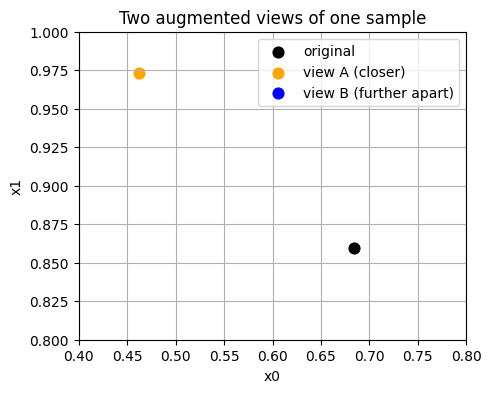

In [12]:
# Visualize the two views and the original
plt.figure()
plt.scatter([x0[0]], [x0[1]], s=60, label="original", color="black")
plt.scatter([v1[0]], [v1[1]], s=60, label="view A (closer)", color="orange")
plt.scatter([v2[0]], [v2[1]], s=60, label="view B (further apart)", color="blue")

# Set axis limits manually
plt.xlim(0.4, 0.8)   # set x-axis scale
plt.ylim(0.8, 1)   # set y-axis scale

plt.legend()
plt.title("Two augmented views of one sample")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

### 4.2 Build a small batch of pairs

We now collect a tiny batch from the training set for demonstration.  
We will keep it small to print everything clearly.

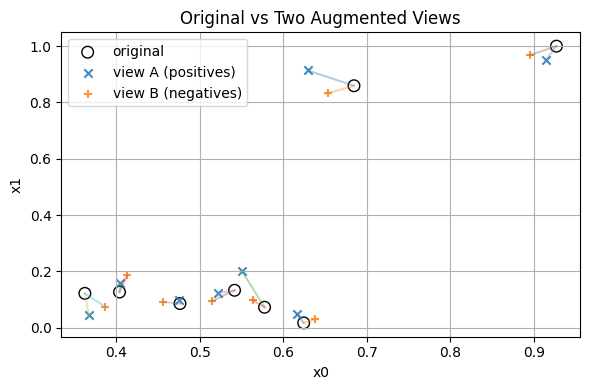

In [13]:
# Plot original + both views, with connecting lines
plt.figure(figsize=(6, 4))  # set figure/panel size

batch_idx = np.arange(8)  # first eight points
xb = X_train[batch_idx]

# Create two views for each item
xa = np.array([augment_view(x) for x in xb])
xb2 = np.array([augment_view(x) for x in xb])

# originals
plt.scatter(
    xb[:, 0], xb[:, 1],
    s=70, marker="o", facecolors="none", edgecolors="k",
    label="original"
)

# augmented views
plt.scatter(xa[:, 0],  xa[:, 1],  marker="x", alpha=0.85, label="view A (positives)")
plt.scatter(xb2[:, 0], xb2[:, 1], marker="+", alpha=0.85, label="view B (negatives)")

# connect each original to its two augmented views
for i in range(len(xb)):
    plt.plot([xb[i, 0], xa[i, 0]],  [xb[i, 1], xa[i, 1]],  alpha=0.35)
    plt.plot([xb[i, 0], xb2[i, 0]], [xb[i, 1], xb2[i, 1]], alpha=0.35)

# finalize plot
plt.title("Original vs Two Augmented Views")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
#plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()


```{admonition} What counts as a negative here
For a given anchor in view A, all other items in view B act as negatives.  
We do not need explicit negative labels, the batch itself supplies them.
```

### 4.3 Augmentations for chemistry conditions

We now design a view function for the 4D chemistry conditions.  
The function applies small jitters and clips to the physical bounds.  
We also view changes step by step.

In [14]:
def augment_conditions_stepwise(v, T_std=2.0, c_rel=0.03, i_std=5.0, time_rel=0.05,
                               bounds=((25,150),(0.05,1.20),(10,200),(0.2,8.0))):
    v = np.array(v, dtype=float)
    T, c, i, t = v
    # Step 1: temperature jitter
    T1 = T + rng.normal(0.0, T_std)
    # Step 2: relative concentration change
    c1 = c * (1.0 + rng.normal(0.0, c_rel))
    # Step 3: current jitter
    i1 = i + rng.normal(0.0, i_std)
    # Step 4: time relative jitter
    t1 = t * (1.0 + rng.normal(0.0, time_rel))
    # Step 5: clip
    (Tmin, Tmax), (cmin, cmax), (imin, imax), (tmin, tmax) = bounds
    out = np.array([
        np.clip(T1, Tmin, Tmax),
        np.clip(c1, cmin, cmax),
        np.clip(i1, imin, imax),
        np.clip(t1, tmin, tmax)
    ])
    steps = {
        "original": v,
        "after_T": np.array([T1, c, i, t]),
        "after_conc": np.array([T1, c1, i, t]),
        "after_current": np.array([T1, c1, i1, t]),
        "after_time": np.array([T1, c1, i1, t1]),
        "clipped": out,
    }

    return out, steps

# Pick one sample and visualize the steps
sample_idx = 5
v0 = X_chem4d[sample_idx]
v1, steps = augment_conditions_stepwise(v0)

print("Original:", v0)
for k in ["after_T","after_conc","after_current","after_time","clipped"]:
    print(f"{k:>13}:", np.round(steps[k], 3))



Original: [78.447   0.4713 82.1547  2.013 ]
      after_T: [76.087  0.471 82.155  2.013]
   after_conc: [76.087  0.466 82.155  2.013]
after_current: [76.087  0.466 80.534  2.013]
   after_time: [76.087  0.466 80.534  2.029]
      clipped: [76.087  0.466 80.534  2.029]


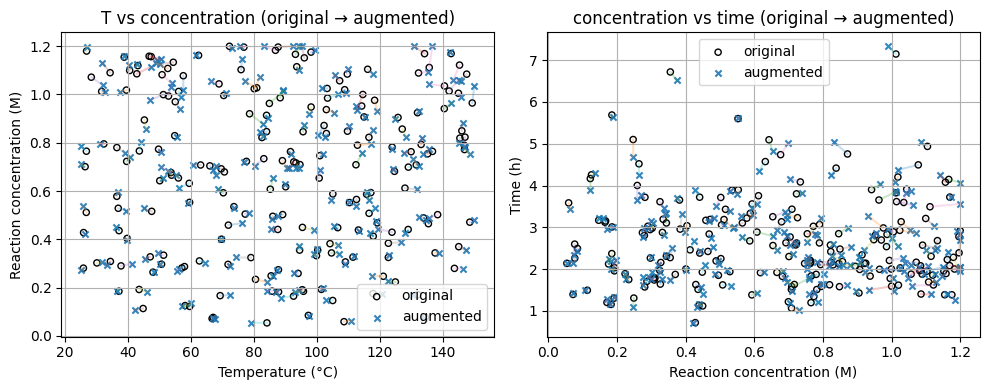

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Tunable parameters for augmentation ---
T_std   = 2.0
c_rel   = 0.03
i_std   = 5.0
time_rel = 0.05
bounds = ((25,150),(0.05,1.20),(10,200),(0.2,8.0))

# --- Sampling from your original 4D matrix ---
# expects X_chem4d with columns [T, conc, current, time]
n_samples = 200
rng_vis = np.random.default_rng(18)
idx = rng_vis.choice(len(X_chem4d), size=n_samples, replace=False)

orig = np.asarray(X_chem4d[idx], dtype=float)
T0, C0, I0, t0 = orig.T

# --- Apply your stepwise augmenter to each sample ---
# relies on augment_conditions_stepwise and a global rng used inside it
aug = np.empty_like(orig)
for k, v in enumerate(orig):
    out, _ = augment_conditions_stepwise(
        v,
        T_std=T_std,
        c_rel=c_rel,
        i_std=i_std,
        time_rel=time_rel,
        bounds=bounds
    )
    aug[k] = out

T1, C1, I1, t1 = aug.T

# --- Plots ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)

# Panel 1: T vs concentration
ax = axs[0]
ax.scatter(T0, C0, s=20, facecolors="none", edgecolors="k", label="original")
ax.scatter(T1, C1, s=20, marker="x", alpha=0.9, label="augmented")
for i in range(n_samples):
    ax.plot([T0[i], T1[i]], [C0[i], C1[i]], alpha=0.25)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Reaction concentration (M)")
ax.set_title("T vs concentration (original → augmented)")
ax.legend()
ax.grid(True)

# Panel 2: concentration vs time
ax = axs[1]
ax.scatter(C0, t0, s=20, facecolors="none", edgecolors="k", label="original")
ax.scatter(C1, t1, s=20, marker="x", alpha=0.9, label="augmented")
for i in range(n_samples):
    ax.plot([C0[i], C1[i]], [t0[i], t1[i]], alpha=0.25)
ax.set_xlabel("Reaction concentration (M)")
ax.set_ylabel("Time (h)")
ax.set_title("concentration vs time (original → augmented)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

```{admonition} Labeling Pairs
>Positive pair = an original with its own augmented version. 

>Negative pair = an original with an augmented point from a different row.
```

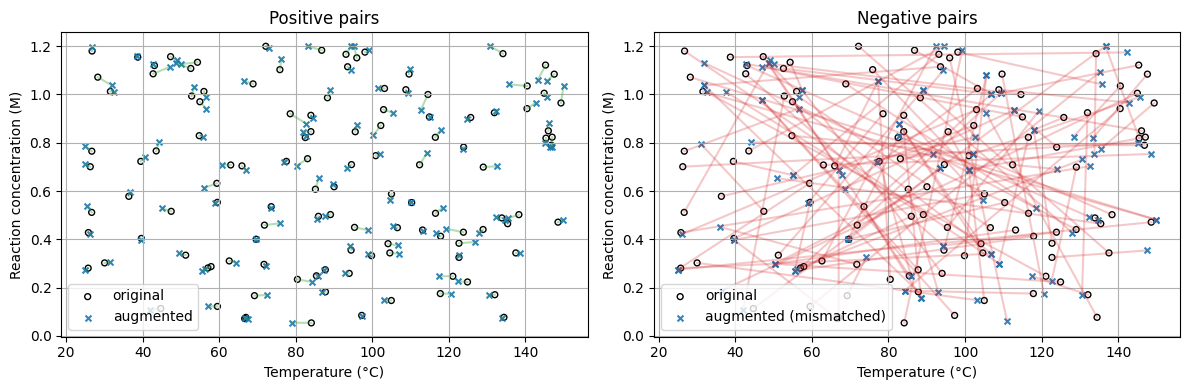

Pairs matrix shapes: (240, 4) (240, 4) (240,)
Example rows:
y=1  orig=[83.973  0.846 45.915  2.133]  pair=[81.87   0.846 38.295  2.078]
y=1  orig=[89.086  0.502 39.465  2.249]  pair=[87.673  0.496 38.113  2.126]
y=1  orig=[ 56.027   1.012 133.294   7.148]  pair=[ 56.635   0.99  137.152   7.336]


In [16]:
# --- Build positive and negative pairs from orig and aug ---

import numpy as np
import matplotlib.pyplot as plt

assert orig.shape == aug.shape, "Expect orig and aug from cell 2 with the same shape"
n = len(orig)
rng_pairs = np.random.default_rng(123)

# pick a subset to keep plots readable
m = min(120, n)  # cap at 120 lines
sel = rng_pairs.choice(n, size=m, replace=False)

# Positive pairs: (orig[i], aug[i])
Xo_pos = orig[sel]
Xa_pos = aug[sel]

# Negative pairs: (orig[i], aug[j]) with j != i
# Make a derangement over sel to avoid i == j
offs = rng_pairs.integers(1, n, size=m)
perm = (sel + offs) % n
same_mask = perm == sel
if np.any(same_mask):
    perm[same_mask] = (perm[same_mask] + 1) % n

Xo_neg = orig[sel]
Xa_neg = aug[perm]

# Optional: assemble a training-style matrix for later use
# X1: anchor, X2: pair, y: 1 for positive, 0 for negative
X1 = np.vstack([Xo_pos, Xo_neg])
X2 = np.vstack([Xa_pos, Xa_neg])
y  = np.concatenate([np.ones(m, dtype=int), np.zeros(m, dtype=int)])

# --- Plot T vs concentration for positives and negatives ---
T_o_pos, C_o_pos = Xo_pos[:, 0], Xo_pos[:, 1]
T_a_pos, C_a_pos = Xa_pos[:, 0], Xa_pos[:, 1]

T_o_neg, C_o_neg = Xo_neg[:, 0], Xo_neg[:, 1]
T_a_neg, C_a_neg = Xa_neg[:, 0], Xa_neg[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# Panel A: positive pairs
ax = axs[0]
ax.scatter(T_o_pos, C_o_pos, s=18, facecolors="none", edgecolors="k", label="original")
ax.scatter(T_a_pos, C_a_pos, s=18, marker="x", alpha=0.9, label="augmented")
for i in range(m):
    ax.plot([T_o_pos[i], T_a_pos[i]], [C_o_pos[i], C_a_pos[i]], alpha=0.35, color="tab:green")
ax.set_title("Positive pairs")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Reaction concentration (M)")
ax.legend()
ax.grid(True)

# Panel B: negative pairs
ax = axs[1]
ax.scatter(T_o_neg, C_o_neg, s=18, facecolors="none", edgecolors="k", label="original")
ax.scatter(T_a_neg, C_a_neg, s=18, marker="x", alpha=0.9, label="augmented (mismatched)")
for i in range(m):
    ax.plot([T_o_neg[i], T_a_neg[i]], [C_o_neg[i], C_a_neg[i]], alpha=0.25, color="tab:red")
ax.set_title("Negative pairs")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Reaction concentration (M)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# Peek at a few rows to confirm labels and indices
print("Pairs matrix shapes:", X1.shape, X2.shape, y.shape)
print("Example rows:")
for k in range(3):
    print(f"y={y[k]}  orig={np.round(X1[k], 3)}  pair={np.round(X2[k], 3)}")

With data augmentation, without doing any new experiments, we "create" labels by pairing. 
---

## 5. InfoNCE loss step-by-step


---

## 5. InfoNCE loss step-by-step

The **InfoNCE loss** is a core objective in contrastive learning. It makes embeddings of **positive pairs** (two augmentations of the same input) close, and **negative pairs** (different samples) far apart.



**Step 1: Normalize the embeddings**

Given two batches of embeddings $x_a$ and $x_b$ of shape $N \times d$, normalize them along the feature dimension:

$
\tilde{x}_a = \frac{x_a}{\|x_a\|_2}, \quad
\tilde{x}_b = \frac{x_b}{\|x_b\|_2}
$

This ensures that cosine similarity equals the dot product.





**Step 2: Compute the similarity matrix**

The cosine similarity between samples is:

$
S_{ij} = \tilde{x}_{a,i} \cdot \tilde{x}_{b,j}
$

- $S_{ii}$ → positive pair (same sample, two augmentations)  
- $S_{ij}$ for $i \ne j$ → negative pairs (different samples)



**Step 3: Apply temperature scaling**

A temperature parameter $\tau$ sharpens or softens similarity scores:

$
\text{logits}_{ij} = \frac{S_{ij}}{\tau}
$

A smaller $\tau$ (e.g., $0.1$) increases contrast between pairs.


**Step 4: Compute the InfoNCE loss**

For each sample $i$:

$
\ell_i = -\log
\frac{\exp(S_{ii} / \tau)}{\sum_{j=1}^{N} \exp(S_{ij} / \tau)}
$

The overall loss:

$
\mathcal{L}_{\text{InfoNCE}} = \frac{1}{N} \sum_{i=1}^{N} \ell_i
$

Intuitively, the numerator measures similarity of the correct positive pair,  
and the denominator sums over all possible pairs, acting like a softmax classifier.




>Here is a numerical example (2D, 3 Samples) for you to understand this process:

Let $N=3$ and each embedding have 2 dimensions:

$
x_a =
\begin{bmatrix}
1 & 0 \\
0 & 1 \\
1 & 1
\end{bmatrix},
\quad
x_b =
\begin{bmatrix}
1 & 1 \\
1 & -1 \\
0 & 1
\end{bmatrix}
$



>Normalize each row:

$
\|x_a\| =
\begin{bmatrix}
1 \\
1 \\
\sqrt{2}
\end{bmatrix},
\quad
\|x_b\| =
\begin{bmatrix}
\sqrt{2} \\
\sqrt{2} \\
1
\end{bmatrix}
$

$
\tilde{x}_a =
\begin{bmatrix}
1 & 0 \\
0 & 1 \\
0.707 & 0.707
\end{bmatrix},
\quad
\tilde{x}_b =
\begin{bmatrix}
0.707 & 0.707 \\
0.707 & -0.707 \\
0 & 1
\end{bmatrix}
$


>Compute similarity matrix $S = \tilde{x}_a \tilde{x}_b^T$


$
S =
\begin{bmatrix}
0.707 & 0.707 & 0.0 \\
0.707 & -0.707 & 1.0 \\
0.999 & 0.0 & 0.707
\end{bmatrix}
$



>Apply temperature $\tau = 0.2$

$
\text{logits} = \frac{S}{0.2}
$



>Compute loss for sample $i=1$

$
\ell_1 = -\log \frac{\exp(0.707 / 0.2)}{\exp(0.707 / 0.2) + \exp(0.707 / 0.2) + \exp(0 / 0.2)}
$

$
\exp(0.707 / 0.2) = e^{3.535} \approx 34.3, \quad \exp(0) = 1
$

$
\ell_1 = -\log\frac{34.3}{34.3 + 34.3 + 1} = -\log(0.494) \approx 0.706
$

You can repeat for $i=2$ and $i=3$, then average to get:

$
\mathcal{L}_{\text{InfoNCE}} = \frac{1}{3} (\ell_1 + \ell_2 + \ell_3)
$




>Finally, we need to normalize and compute pairwise cosine similarities.

The encoder network is not required yet.  
We only take the two views `xa` and `xb2`, normalize them, then compute a similarity matrix.

In [17]:
def l2_normalize_rows(M, eps=1e-9):
    M = np.asarray(M, dtype=float)
    norms = np.linalg.norm(M, axis=1, keepdims=True) + eps
    return M / norms

za = l2_normalize_rows(xa)   # embeddings for view A
zb = l2_normalize_rows(xb2)  # embeddings for view B

# Pairwise cosine similarities S[i,j] = za[i] dot zb[j]
S = za @ zb.T

show_shape("za", za)
show_shape("zb", zb)
show_shape("S", S)
print("First 3x3 block of S:\n", S[:3,:3])

za.shape: (8, 2)
zb.shape: (8, 2)
S.shape: (8, 8)
First 3x3 block of S:
 [[0.9981 0.8564 0.706 ]
 [0.8601 0.9985 0.982 ]
 [0.7814 0.9814 0.9987]]


```{admonition} Note
Row `i` and column `i` correspond to the positive pair for item `i`.  
Large diagonal values are good for this loss.
```

### 5.2 InfoNCE with a temperature scalar

We use a small positive constant `tau` that controls the softness of the softmax.  
Smaller `tau` makes the softmax sharper.

The per-item loss with positive at index `i` is:

$
\ell_i = -\log \frac{\exp(S_{ii}/\tau)}{\sum_{j=1}^N \exp(S_{ij}/\tau)}
$

The batch loss is the mean of $\ell_i$.

In [18]:
def info_nce_from_sim(S, tau=0.1):
    # S is an NxN similarity matrix between view A rows and view B rows
    N = S.shape[0]
    logits = S / tau
    # subtract max per row for numerical stability
    logits = logits - logits.max(axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    denom = exp_logits.sum(axis=1, keepdims=True)
    prob_pos = exp_logits[np.arange(N), np.arange(N)] / denom.ravel()
    loss = -np.log(np.clip(prob_pos, 1e-12, 1.0)).mean()
    return float(loss), prob_pos

loss_val, ppos = info_nce_from_sim(S, tau=0.1)
print("InfoNCE loss:", round(loss_val, 4))
print("Prob of positive pair per item:", np.round(ppos, 4))

InfoNCE loss: 1.5839
Prob of positive pair per item: [0.4156 0.1772 0.1667 0.1692 0.1723 0.1825 0.1506 0.3194]


### 5.3 Symmetric loss

Often we also compute the reverse direction by swapping the roles of A and B, then average the two losses.  
This can improve stability.

In [19]:
loss_ab, _ = info_nce_from_sim(za @ zb.T, tau=0.1)
loss_ba, _ = info_nce_from_sim(zb @ za.T, tau=0.1)
print("AB direction loss:", round(loss_ab, 4))
print("BA direction loss:", round(loss_ba, 4))
print("Symmetric loss:", round((loss_ab + loss_ba)/2.0, 4))

AB direction loss: 1.5839
BA direction loss: 1.5919
Symmetric loss: 1.5879


```{admonition} Tip
When debugging a new contrastive implementation, start with very small batches and print the intermediate arrays.  
You can catch indexing mistakes with human eyes before moving to larger experiments.
```



### 5.4 Tiny encoder for contrastive learning

With `torch` installed, we fit a small encoder that maps 2D inputs to a 2D embedding and uses InfoNCE.  

The goal is to see the points cluster by identity.



### 6.1 Define a simple dataset and encoder

In [20]:
if torch is not None:

    class PairDataset(Dataset):
        def __init__(self, X_array, aug_fn, n_items=240):
            self.X = np.asarray(X_array, dtype=np.float32)
            self.aug_fn = aug_fn
            self.n_items = min(n_items, len(self.X))

        def __len__(self):
            return self.n_items

        def __getitem__(self, idx):
            x = self.X[idx]
            v1 = self.aug_fn(x)
            v2 = self.aug_fn(x)
            return v1.astype(np.float32), v2.astype(np.float32)

    class TinyEncoder(nn.Module):
        def __init__(self, in_dim=2, out_dim=2, hidden=32):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, out_dim),
            )
        def forward(self, x):
            z = self.net(x)
            z = F.normalize(z, p=2, dim=1)
            return z

We compute the pairwise similarities, then the loss, then one optimizer step.  
We print shapes to keep it clear.

In [21]:
if torch is not None:
    ds = PairDataset(X_train, augment_view, n_items=len(X_train))
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    enc = TinyEncoder(in_dim=2, out_dim=2, hidden=32)
    opt = torch.optim.Adam(enc.parameters(), lr=1e-2)

    xb_a, xb_b = next(iter(dl))
    show_shape("xb_a torch", xb_a)
    show_shape("xb_b torch", xb_b)

    enc.train()
    z_a = enc(xb_a)
    z_b = enc(xb_b)

    show_shape("z_a", z_a)
    show_shape("z_b", z_b)

    # Similarity matrix
    S = z_a @ z_b.T
    tau = 0.1
    logits = S / tau
    logits = logits - logits.max(dim=1, keepdim=True).values
    exp_logits = torch.exp(logits)
    prob_pos = torch.diag(exp_logits) / exp_logits.sum(dim=1)
    loss = -torch.log(torch.clamp(prob_pos, min=1e-12)).mean()

    print("Loss (one step):", float(loss.item()))

xb_a torch.shape: torch.Size([64, 2])
xb_b torch.shape: torch.Size([64, 2])
z_a.shape: torch.Size([64, 2])
z_b.shape: torch.Size([64, 2])
Loss (one step): 3.880275249481201


In [22]:
if torch is not None:
    # Backprop once
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    print("Step done.")

Step done.


We split the loop across two cells to keep each piece small.  
First we define the function that computes batch loss.  
Then we run a tiny loop and record losses for a simple plot.

step 000  loss=3.9318


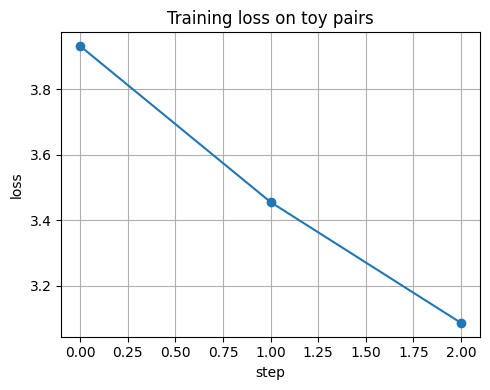

In [23]:
if torch is not None:
    def batch_info_nce(encoder, xb_a, xb_b, tau=0.1):
        z_a = encoder(xb_a)
        z_b = encoder(xb_b)
        S = z_a @ z_b.T
        logits = S / tau
        logits = logits - logits.max(dim=1, keepdim=True).values
        exp_logits = torch.exp(logits)
        denom = exp_logits.sum(dim=1)
        prob_pos = torch.diag(exp_logits) / denom
        loss = -torch.log(torch.clamp(prob_pos, min=1e-12)).mean()
        return loss

    # Reinit encoder for a clean run
    enc = TinyEncoder(in_dim=2, out_dim=2, hidden=32)
    opt = torch.optim.Adam(enc.parameters(), lr=1e-2)

    losses = []
    enc.train()
    for step, (xa_b, xb_b) in enumerate(dl):
        loss = batch_info_nce(enc, xa_b, xb_b, tau=0.1)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        if step % 10 == 0:
            print(f"step {step:03d}  loss={losses[-1]:.4f}")
    plt.figure()
    plt.plot(losses, marker="o")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training loss on toy pairs")
    plt.tight_layout()
    plt.show()

step 000  loss=3.1611


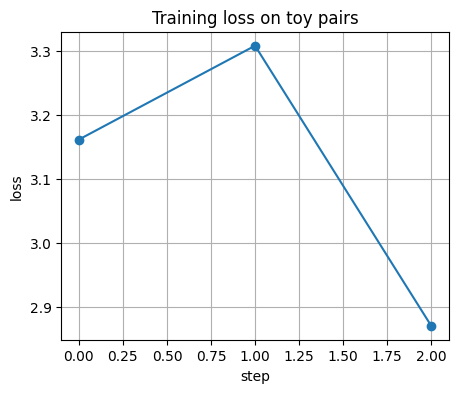

In [24]:
if torch is not None:
    losses = []
    enc.train()
    for step, (xa_b, xb_b) in enumerate(dl):
        loss = batch_info_nce(enc, xa_b, xb_b, tau=0.1)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        losses.append(float(loss.item()))
        if step % 10 == 0:
            print(f"step {step:03d}  loss={losses[-1]:.4f}")
    plt.figure()
    plt.plot(losses, marker="o")
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Training loss on toy pairs")
    plt.show()

```{admonition} ⏰ Exercise
Try a smaller learning rate `5e-3` and then a larger one `2e-2`.  
Does the loss curve become smoother or noisier?
```

### 5.5 Visualize the learned embedding with T-SNE

We embed the test set using the trained encoder.  
Then we color by the hidden class to see clusters.

z_test_np.shape: (60, 2)


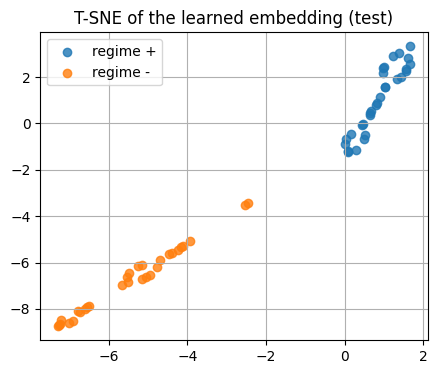

In [25]:
if torch is not None:
    enc.eval()
    with torch.no_grad():
        z_test = enc(torch.from_numpy(X_test))
        z_test_np = z_test.cpu().numpy()

    show_shape("z_test_np", z_test_np)

    # T-SNE on the learned embedding
    tsne = TSNE(n_components=2, random_state=0, perplexity=20, init="random")
    Z2 = tsne.fit_transform(z_test_np)

    plt.figure()
    plt.scatter(Z2[y_test==1,0], Z2[y_test==1,1], alpha=0.8, label="regime +")
    plt.scatter(Z2[y_test==0,0], Z2[y_test==0,1], alpha=0.8, label="regime -")
    plt.title("T-SNE of the learned embedding (test)")
    plt.legend()
    plt.show()

### 5.6 Tiny encoder trained on chemistry 4D conditions

We now repeat the training on the chemistry dataset with 4 features.  
We monitor the InfoNCE loss and later run a linear probe.

step 000  loss=4.5104


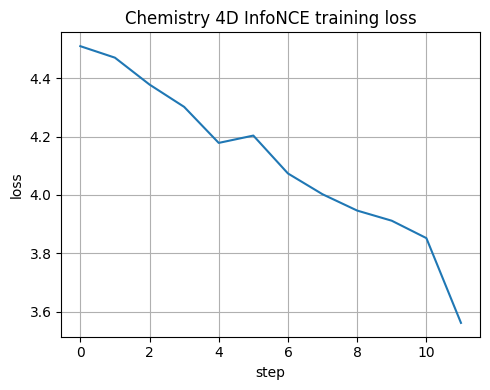

In [26]:
if torch is not None:

    class ChemPairDataset(Dataset):
        def __init__(self, X_array, aug_fn, n_items=None):
            self.X = np.asarray(X_array, dtype=np.float32)
            self.aug_fn = aug_fn
            self.n_items = len(self.X) if n_items is None else min(n_items, len(self.X))
        def __len__(self):
            return self.n_items
        def __getitem__(self, idx):
            x = self.X[idx]
            v1, _ = augment_conditions_stepwise(x)
            v2, _ = augment_conditions_stepwise(x)
            return v1.astype(np.float32), v2.astype(np.float32)

    chem_ds = ChemPairDataset(X_chem4d, augment_conditions_stepwise)
    chem_dl = DataLoader(chem_ds, batch_size=128, shuffle=True)

    enc_chem = TinyEncoder(in_dim=4, out_dim=8, hidden=64)
    opt_chem = torch.optim.Adam(enc_chem.parameters(), lr=1e-3)

    losses_chem = []
    enc_chem.train()
    for step, (xa_b, xb_b) in enumerate(chem_dl):
        loss = batch_info_nce(enc_chem, xa_b, xb_b, tau=0.15)
        opt_chem.zero_grad(set_to_none=True)
        loss.backward()
        opt_chem.step()
        losses_chem.append(float(loss.item()))
        if step % 20 == 0:
            print(f"step {step:03d}  loss={losses_chem[-1]:.4f}")
    plt.figure()
    plt.plot(losses_chem)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.title("Chemistry 4D InfoNCE training loss")
    plt.tight_layout()
    plt.show()

Z_chem.shape: (1500, 8)


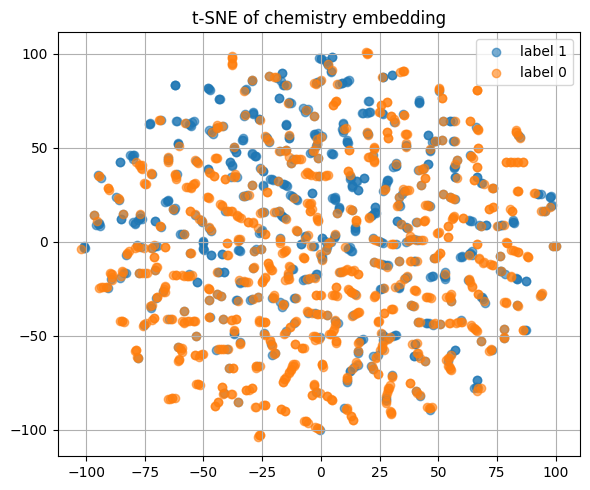

In [27]:
if torch is not None:
    # Embed the dataset and visualize with t-SNE to 2D
    enc_chem.eval()
    with torch.no_grad():
        Z_chem = enc_chem(torch.from_numpy(X_chem4d)).cpu().numpy()
    show_shape("Z_chem", Z_chem)

    Z_chem_small, label_small = Z_chem, label

    tsne = TSNE(
        n_components=2,
        perplexity=2,
        learning_rate="auto",
        init="pca",
        random_state=0
    )
    Z2 = tsne.fit_transform(Z_chem_small)

    plt.figure(figsize=(6, 5))
    plt.scatter(Z2[label_small==1, 0], Z2[label_small==1, 1], alpha=0.6, label="label 1")
    plt.scatter(Z2[label_small==0, 0], Z2[label_small==0, 1], alpha=0.6, label="label 0")
    plt.title("t-SNE of chemistry embedding")
    plt.legend()
    plt.tight_layout()
    plt.show()



Here is how encoded reaction conditions look like.

In [28]:
Z_chem_small[3:]

array([[-0.3774, -0.0671, -0.3289, ...,  0.2484,  0.2479,  0.3608],
       [-0.5051, -0.1294, -0.0723, ..., -0.1609, -0.0412,  0.1268],
       [-0.5335, -0.1025, -0.0166, ..., -0.1515, -0.1029,  0.0774],
       ...,
       [-0.0384, -0.0597, -0.4262, ...,  0.3815,  0.4959,  0.4415],
       [-0.5341, -0.1024, -0.011 , ..., -0.1525, -0.1054,  0.0746],
       [-0.5121, -0.1056,  0.0804, ..., -0.2198, -0.1624, -0.0149]],
      shape=(1497, 8), dtype=float32)

```{admonition} ⏰ Exercise
Change `out_dim` from 3 to 2 and repeat the t-SNE plot.  
See if the classes are more separated or less separated.
```

---

## 6. Linear evaluation and simple retrieval

After contrastive pretraining, a common step is **linear evaluation**.  
We freeze the encoder and train a simple classifier on top with a small labeled set.

### 6.1 Linear probe using logistic regression

In [29]:
# If torch is missing, we will use raw features as a dummy "embedding"
if torch is None:
    Z_train = X_train.copy()
    Z_test = X_test.copy()
else:
    enc.eval()
    with torch.no_grad():
        Z_train = enc(torch.from_numpy(X_train)).cpu().numpy()
        Z_test = enc(torch.from_numpy(X_test)).cpu().numpy()

show_shape("Z_train", Z_train)
show_shape("Z_test", Z_test)

Z_train.shape: (180, 2)
Z_test.shape: (60, 2)


In [30]:
Z_train[:3]

array([[ 0.2661,  0.9639],
       [-0.884 ,  0.4675],
       [-0.3905,  0.9206]], dtype=float32)

As you can see below, after converted to embedding, with simple machine learning model like `LogisticRegression()` you can easily classify what was quite challenging to do before.

In [31]:
sc = StandardScaler().fit(Z_train)
Ztr = sc.transform(Z_train)
Zte = sc.transform(Z_test)

clf = LogisticRegression(max_iter=500, random_state=0)
clf.fit(Ztr, y_train)

y_proba = clf.predict_proba(Zte)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))

Accuracy: 1.0
AUC: 1.0


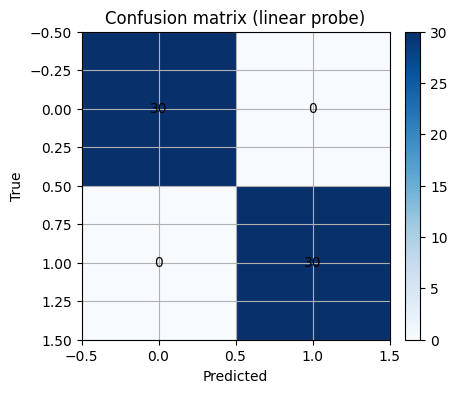

In [32]:
# Confusion matrix for a quick look
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix (linear probe)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

```{admonition} Exercise 7.1
Change the decision threshold from `0.5` to `0.3` and to `0.7`.  
Plot ROC and mark the two points.  
Discuss how the tradeoff moves.
```

### 6.2 Retrieval with cosine similarity

We take one query from the test set and retrieve the nearest neighbors in the embedding space.  
This is useful to propose similar conditions or spectra for follow up experiments.

In [33]:
def topk_cosine(query, items, k=5):
    q = query.reshape(1, -1)
    items_n = normalize(items, norm="l2", axis=1)
    q_n = normalize(q, norm="l2", axis=1)
    sims = (items_n @ q_n.T).ravel()
    idx = np.argsort(-sims)[:k]
    return idx, sims[idx]

q_idx = 2
q = Z_test[q_idx]
idx, sims = topk_cosine(q, Z_test, k=6)  # include itself

print("Query is index", q_idx, "with class", y_test[q_idx])
print("Top indices:", idx)
print("Top sims   :", np.round(sims, 3))

Query is index 2 with class 1
Top indices: [ 2 58 42 43 49 15]
Top sims   : [1. 1. 1. 1. 1. 1.]


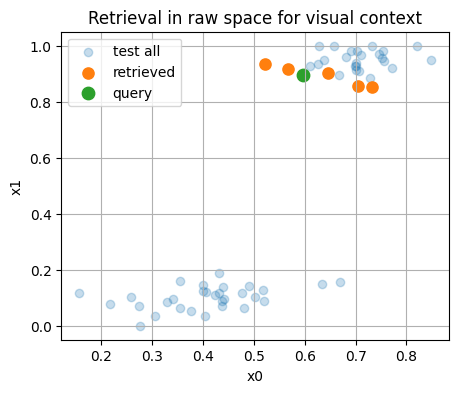

In [34]:
# Visualize query and neighbors in raw 2D space for context
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], alpha=0.25, label="test all")
plt.scatter(X_test[idx,0], X_test[idx,1], s=65, label="retrieved")
plt.scatter([X_test[q_idx,0]],[X_test[q_idx,1]], s=80, label="query")
plt.xlabel("x0"); plt.ylabel("x1")
plt.title("Retrieval in raw space for visual context")
plt.legend()
plt.show()

```{admonition} ⏰ Exercise
Replace `q_idx = 2` with another index.  
Check if the nearest neighbors share the same label more often than random picks.
```


### 6.3 Linear probe and curves on chemistry 4D

We embed the chemistry dataset if an encoder was trained, then fit a probe.  
We plot ROC and Precision-Recall.

Chemistry 4D Accuracy: 0.704
Chemistry 4D AUC: 0.763


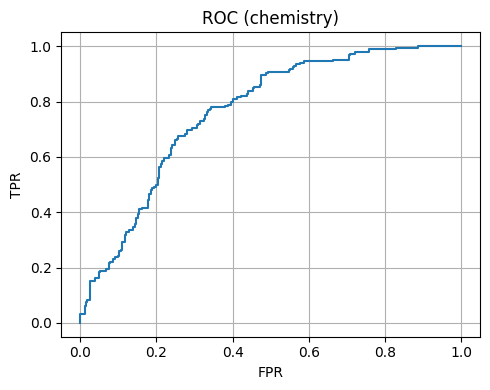

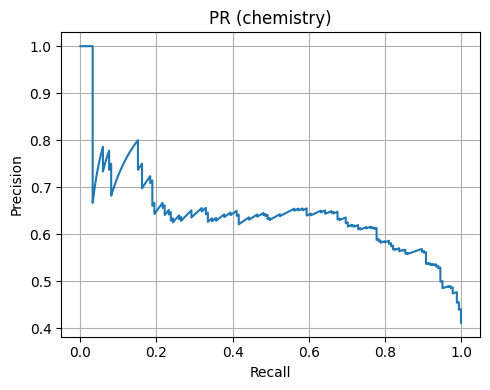

In [35]:
if torch is None:
    Z_chem_emb = X_chem4d.copy()
else:
    enc_chem.eval()
    with torch.no_grad():
        Z_chem_emb = enc_chem(torch.from_numpy(X_chem4d)).cpu().numpy()

Ztr_c, Zte_c, ytr_c, yte_c = train_test_split(Z_chem_emb, label, test_size=0.3, random_state=18, stratify=label)
sc_c = StandardScaler().fit(Ztr_c)
Ztr_c2 = sc_c.transform(Ztr_c)
Zte_c2 = sc_c.transform(Zte_c)

clf_c = LogisticRegression(max_iter=1000, random_state=0).fit(Ztr_c2, ytr_c)
proba_c = clf_c.predict_proba(Zte_c2)[:,1]
pred_c = (proba_c >= 0.5).astype(int)

print("Chemistry 4D Accuracy:", round(accuracy_score(yte_c, pred_c), 3))
print("Chemistry 4D AUC:", round(roc_auc_score(yte_c, proba_c), 3))

fpr, tpr, _ = roc_curve(yte_c, proba_c)
pr_p, pr_r, _ = precision_recall_curve(yte_c, proba_c)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (chemistry)"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(pr_r, pr_p); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (chemistry)"); plt.tight_layout(); plt.show()

---

## 7. Mini case studies

Contrastive learning depends on good view design.  
In chemistry, the view should preserve the identity of the sample while adding realistic variation.

### 7.1 Spectra toy example: IR-like peaks with noise

We synthesize spectra as sums of Gaussians.  
Two views of the same sample will get small baseline shifts and noise.

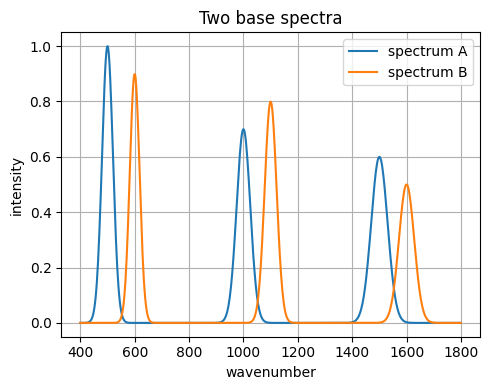

In [36]:
# Build synthetic 1D spectra
def gaussian(x, mu, sig, amp):
    return amp * np.exp(-0.5 * ((x-mu)/sig)**2)

def make_spectrum(x, peaks):
    y = np.zeros_like(x)
    for (mu, sig, amp) in peaks:
        y += gaussian(x, mu, sig, amp)
    return y

x_grid = np.linspace(400, 1800, 600)  # wavenumbers
peaks_A = [(500, 20, 1.0), (1000, 25, 0.7), (1500, 30, 0.6)]
peaks_B = [(600, 18, 0.9), (1100, 22, 0.8), (1600, 28, 0.5)]

spec_A = make_spectrum(x_grid, peaks_A)
spec_B = make_spectrum(x_grid, peaks_B)
plt.figure()
plt.plot(x_grid, spec_A, label="spectrum A")
plt.plot(x_grid, spec_B, label="spectrum B")
plt.xlabel("wavenumber")
plt.ylabel("intensity")
plt.title("Two base spectra")
plt.legend()
plt.tight_layout()
plt.show()

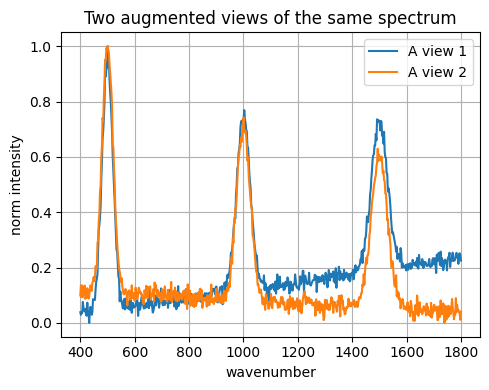

In [37]:
# Augmentations for spectra
def add_baseline(y, slope_std=0.0005):
    slope = rng.normal(0.0, slope_std)
    baseline = slope * (np.arange(len(y)) - len(y)/2.0)
    return y + baseline

def add_noise(y, std=0.02):
    return y + rng.normal(0.0, std, size=len(y))

def scale_intensity(y, s_std=0.05):
    s = 1.0 + rng.normal(0.0, s_std)
    return y * s

def normalize_minmax(y):
    ymin, ymax = y.min(), y.max()
    if ymax - ymin < 1e-9:
        return y.copy()
    return (y - ymin) / (ymax - ymin)

def view_spectrum(y):
    z = add_baseline(y, 0.0004)
    z = add_noise(z, 0.02)
    z = scale_intensity(z, 0.03)
    return normalize_minmax(z)

# Make two views for A
vA1 = view_spectrum(spec_A)
vA2 = view_spectrum(spec_A)

plt.figure()
plt.plot(x_grid, vA1, label="A view 1")
plt.plot(x_grid, vA2, label="A view 2")
plt.xlabel("wavenumber"); plt.ylabel("norm intensity")
plt.title("Two augmented views of the same spectrum")
plt.legend()
plt.tight_layout()
plt.show()

Below, you will see how constrative learning helps convert the spectrum data into embeddings with careful data augmentation and these embeddings are used to downstream tasks like classification.

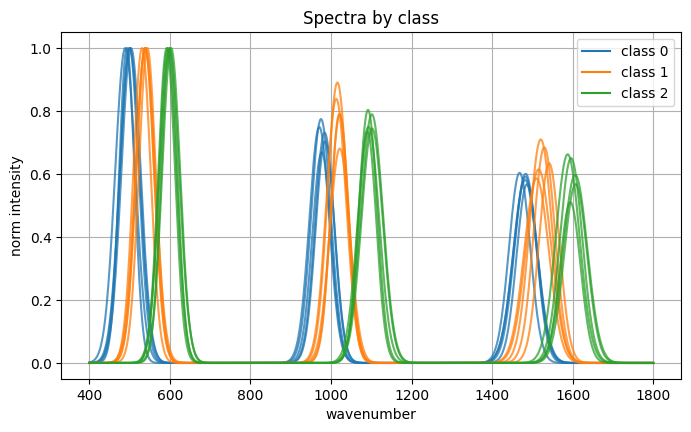

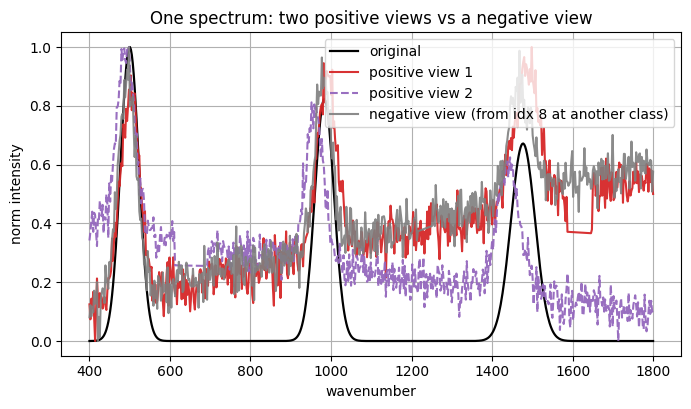

Dataset:
  spectra array shape: (90, 600) dtype: float32
  labels array shape: (90,) classes: [0, 1, 2]

Picked spectrum index: 7 class: 0
  original shape: (600,)
  pos1 shape: (600,)
  pos2 shape: (600,)
  neg view source idx: 8 class: 0

Encoded representations (first 6 of 16):
  enc(original): [ 0.2405  0.3901  0.0404  0.0448  0.0384 -0.4534]
  enc(pos1):     [ 0.079   0.4712 -0.0014  0.1769  0.0065 -0.4767]
  enc(pos2):     [ 0.2844  0.2496 -0.0043  0.0928  0.0464 -0.515 ]
  enc(neg):      [ 0.1967  0.3172  0.0338  0.1879  0.0506 -0.498 ]


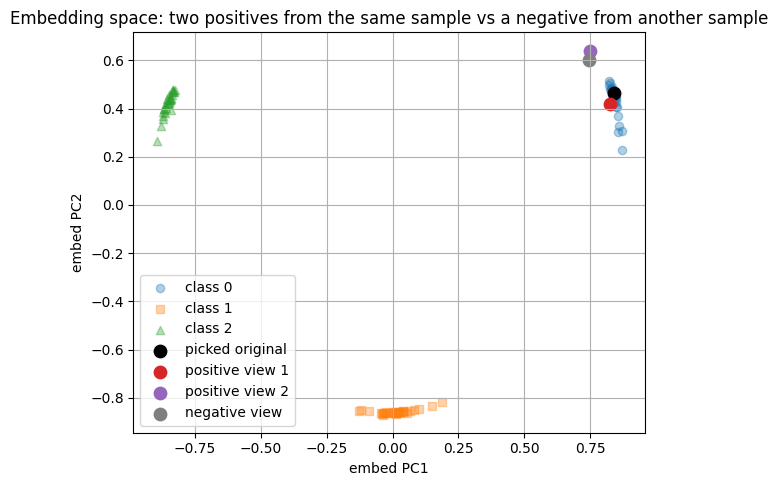


Classifier on embeddings:
  train size: 36 test size: 54
  test accuracy: 1.0


C:\Users\52377\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [38]:
# Spectra demo: three classes with different peak centers, stronger augmentation,
# contrastive training, and a plot that marks positives vs a negative.

import numpy as np
import matplotlib.pyplot as plt

# Optional PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception:
    torch = None

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

rng = np.random.default_rng(11)

# ---- helpers ----
def gaussian(x, mu, sig, amp):
    return amp * np.exp(-0.5 * ((x - mu) / sig) ** 2)

def make_spectrum(x, peaks):
    y = np.zeros_like(x)
    for (mu, sig, amp) in peaks:
        y += gaussian(x, mu, sig, amp)
    return y

def add_baseline(y, slope_std=0.0015):
    slope = rng.normal(0.0, slope_std)
    baseline = slope * (np.arange(len(y)) - len(y) / 2.0)
    return y + baseline

def add_noise(y, std=0.06):
    return y + rng.normal(0.0, std, size=len(y))

def scale_intensity(y, s_std=0.15):
    s = 1.0 + rng.normal(0.0, s_std)
    return y * s

def band_dropout(y, max_width=30, p=0.4):
    """Randomly zero a contiguous window to simulate occlusion."""
    if rng.random() < p:
        n = len(y)
        w = rng.integers(6, max_width + 1)
        start = rng.integers(0, n - w + 1)
        y = y.copy()
        y[start:start + w] = np.linspace(y[start], y[start + w - 1], w) * 0.2
    return y

def x_warp(y, max_shift_idx=4, max_scale=0.015):
    """Small shift and stretch in the index domain with interpolation."""
    n = len(y)
    ix = np.arange(n)
    shift = rng.integers(-max_shift_idx, max_shift_idx + 1)
    scale = 1.0 + rng.normal(0.0, max_scale)
    ix_new = (ix - shift) * scale
    # clip to valid range and interpolate
    ix_new = np.clip(ix_new, 0, n - 1)
    return np.interp(ix, ix_new, y)

def normalize_minmax(y):
    ymin, ymax = y.min(), y.max()
    if ymax - ymin < 1e-9:
        return y.copy()
    return (y - ymin) / (ymax - ymin)

def view_spectrum(y,
                  noise_std=0.06,
                  slope_std=0.0015,
                  s_std=0.15,
                  do_norm=True):
    """Stronger view generator to make positives look different while staying positive."""
    z = x_warp(y, max_shift_idx=4, max_scale=0.015)
    z = add_baseline(z, slope_std)
    z = add_noise(z, noise_std)
    z = scale_intensity(z, s_std)
    z = band_dropout(z, max_width=35, p=0.5)
    return normalize_minmax(z) if do_norm else z

# ---- build dataset: 3 classes with different peak centers ----
x = np.linspace(400, 1800, 600)

base_centers = [
    [500, 980, 1480],   # class 0 centers
    [540, 1020, 1520],  # class 1 centers shifted
    [600, 1100, 1600],  # class 2 centers shifted further
]
base_sig = [22, 24, 28]
base_amp = [1.0, 0.75, 0.6]

n_per_class = 30
spectra = []
labels = []

for cls, centers in enumerate(base_centers):
    for _ in range(n_per_class):
        peaks = []
        for mu, sig, amp in zip(centers, base_sig, base_amp):
            mu_j = mu + rng.normal(0.0, 6.0)
            sig_j = max(8.0, sig + rng.normal(0.0, 2.0))
            amp_j = max(0.2, amp + rng.normal(0.0, 0.06))
            peaks.append((mu_j, sig_j, amp_j))
        y = make_spectrum(x, peaks)
        spectra.append(y)
        labels.append(cls)

spectra = np.array(spectra).astype(np.float32)  # (N, 600)
labels = np.array(labels)

# ---- plot: classes 0,1,2 together with small variations ----
plt.figure(figsize=(8, 4.5))
colors = ["tab:blue", "tab:orange", "tab:green"]
for cls, color in zip(range(3), colors):
    idx = np.where(labels == cls)[0][:5]
    for i in idx:
        plt.plot(x, normalize_minmax(spectra[i]), alpha=0.75, color=color)
plt.xlabel("wavenumber")
plt.ylabel("norm intensity")
plt.title("Spectra by class")
handles = [plt.Line2D([0], [0], color=c, label=f"class {k}") for k, c in zip(range(3), colors)]
plt.legend(handles=handles)
plt.show()

# ---- augmentation preview: one sample, two positives, plus a negative from another sample ----
pick_idx = 7  # any index
orig = normalize_minmax(spectra[pick_idx])
pos1 = view_spectrum(orig)
pos2 = view_spectrum(orig)

# choose a different sample for the negative example
neg_idx = (pick_idx + 1) % len(spectra)
neg_src = normalize_minmax(spectra[neg_idx])
neg_view = view_spectrum(neg_src)

plt.figure(figsize=(8, 4.2))
plt.plot(x, orig, label="original", color="black", linewidth=1.6)
plt.plot(x, pos1, label="positive view 1", color="tab:red", alpha=0.95)
plt.plot(x, pos2, label="positive view 2", color="tab:purple", linestyle="--", alpha=0.95)
plt.plot(x, neg_view, label=f"negative view (from idx {neg_idx} at another class)", color="tab:gray", alpha=0.9)
plt.xlabel("wavenumber")
plt.ylabel("norm intensity")
plt.title("One spectrum: two positive views vs a negative view")
plt.legend()
plt.show()

# ---- build paired views for contrastive training ----
def make_views(batch):
    v1 = np.stack([view_spectrum(normalize_minmax(s)) for s in batch])
    v2 = np.stack([view_spectrum(normalize_minmax(s)) for s in batch])
    return v1.astype(np.float32), v2.astype(np.float32)

V1, V2 = make_views(spectra)

# ---- encode: SimCLR-style if torch exists, else PCA fallback ----
use_torch = torch is not None

if use_torch:
    class SpecPairDataset(Dataset):
        def __init__(self, V1, V2):
            self.V1 = V1
            self.V2 = V2
        def __len__(self):
            return self.V1.shape[0]
        def __getitem__(self, idx):
            return self.V1[idx], self.V2[idx]

    class Encoder(nn.Module):
        def __init__(self, in_dim=600, out_dim=16):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 256), nn.ReLU(),
                nn.Linear(256, 64), nn.ReLU(),
                nn.Linear(64, out_dim)
            )
        def forward(self, x):
            z = self.net(x)
            return F.normalize(z, p=2, dim=1)

    def info_nce(z1, z2, tau=0.2):
        # positives are the diagonal pairs z1[i] with z2[i]
        # all off diagonals are negatives
        S = z1 @ z2.T
        logits = S / tau
        logits = logits - logits.max(dim=1, keepdim=True).values
        exp_logits = torch.exp(logits)
        denom = exp_logits.sum(dim=1)
        pos = torch.diag(exp_logits)
        loss = -torch.log(pos / denom).mean()
        return loss

    ds = SpecPairDataset(V1, V2)
    dl = DataLoader(ds, batch_size=32, shuffle=True)

    enc = Encoder(in_dim=V1.shape[1], out_dim=16)
    opt = torch.optim.Adam(enc.parameters(), lr=1e-3)

    enc.train()
    for epoch in range(6):
        for v1_b, v2_b in dl:
            opt.zero_grad(set_to_none=True)
            z1 = enc(v1_b)
            z2 = enc(v2_b)
            loss = info_nce(z1, z2, tau=0.2)
            loss.backward()
            opt.step()

    enc.eval()
    with torch.no_grad():
        Z = enc(torch.from_numpy(np.stack([normalize_minmax(s) for s in spectra]))).cpu().numpy()
        Z_orig = enc(torch.from_numpy(orig.reshape(1, -1).astype(np.float32))).cpu().numpy()[0]
        Z_pos1 = enc(torch.from_numpy(pos1.reshape(1, -1).astype(np.float32))).cpu().numpy()[0]
        Z_pos2 = enc(torch.from_numpy(pos2.reshape(1, -1).astype(np.float32))).cpu().numpy()[0]
        Z_neg = enc(torch.from_numpy(neg_view.reshape(1, -1).astype(np.float32))).cpu().numpy()[0]
else:
    pca = PCA(n_components=16, random_state=0).fit(np.vstack([V1, V2]))
    X_norm = np.stack([normalize_minmax(s) for s in spectra]).astype(np.float32)
    Z = pca.transform(X_norm)
    Z_orig = pca.transform(orig.reshape(1, -1).astype(np.float32))[0]
    Z_pos1 = pca.transform(pos1.reshape(1, -1).astype(np.float32))[0]
    Z_pos2 = pca.transform(pos2.reshape(1, -1).astype(np.float32))[0]
    Z_neg = pca.transform(neg_view.reshape(1, -1).astype(np.float32))[0]

# ---- print info for the picked spectrum ----
print("Dataset:")
print("  spectra array shape:", spectra.shape, "dtype:", spectra.dtype)
print("  labels array shape:", labels.shape, "classes:", np.unique(labels).tolist())
print("\nPicked spectrum index:", pick_idx, "class:", labels[pick_idx])
print("  original shape:", orig.shape)
print("  pos1 shape:", pos1.shape)
print("  pos2 shape:", pos2.shape)
print("  neg view source idx:", neg_idx, "class:", labels[neg_idx])

print("\nEncoded representations (first 6 of 16):")
print("  enc(original):", np.round(Z_orig[:6], 4))
print("  enc(pos1):    ", np.round(Z_pos1[:6], 4))
print("  enc(pos2):    ", np.round(Z_pos2[:6], 4))
print("  enc(neg):     ", np.round(Z_neg[:6], 4))

# ---- show how the picked spectrum moves in embedding space, mark pos vs neg ----
pca_embed = PCA(n_components=2, random_state=0).fit(Z)
p_all = pca_embed.transform(Z)
p_orig = pca_embed.transform(Z_orig.reshape(1, -1))
p_pos1 = pca_embed.transform(Z_pos1.reshape(1, -1))
p_pos2 = pca_embed.transform(Z_pos2.reshape(1, -1))
p_neg  = pca_embed.transform(Z_neg.reshape(1, -1))

plt.figure(figsize=(6.6, 5.2))
for cls, marker in zip(range(3), ["o", "s", "^"]):
    idx = np.where(labels == cls)[0]
    plt.scatter(p_all[idx, 0], p_all[idx, 1], alpha=0.35, marker=marker, label=f"class {cls}")
plt.scatter(p_orig[0, 0], p_orig[0, 1], color="black", s=80, label="picked original")
plt.scatter(p_pos1[0, 0], p_pos1[0, 1], color="tab:red", s=80, label="positive view 1")
plt.scatter(p_pos2[0, 0], p_pos2[0, 1], color="tab:purple", s=80, label="positive view 2")
plt.scatter(p_neg[0, 0], p_neg[0, 1], color="tab:gray", s=80, label="negative view")
plt.xlabel("embed PC1")
plt.ylabel("embed PC2")
plt.title("Embedding space: two positives from the same sample vs a negative from another sample")
plt.legend()
plt.show()

# ---- classification on embeddings ----
train_idx = np.concatenate([np.where(labels == c)[0][:12] for c in range(3)])
test_idx  = np.array([i for i in range(len(labels)) if i not in set(train_idx)])

sc = StandardScaler().fit(Z[train_idx])
Ztr = sc.transform(Z[train_idx])
Zte = sc.transform(Z[test_idx])

clf = LogisticRegression(max_iter=1000, multi_class="ovr", random_state=0)
clf.fit(Ztr, labels[train_idx])
pred = clf.predict(Zte)
acc = accuracy_score(labels[test_idx], pred)

print("\nClassifier on embeddings:")
print("  train size:", len(train_idx), "test size:", len(test_idx))
print("  test accuracy:", round(acc, 3))

Now we have a new spectrum and we turn it to embedding with the encoder and feed the embedding to trained model to give prediction.

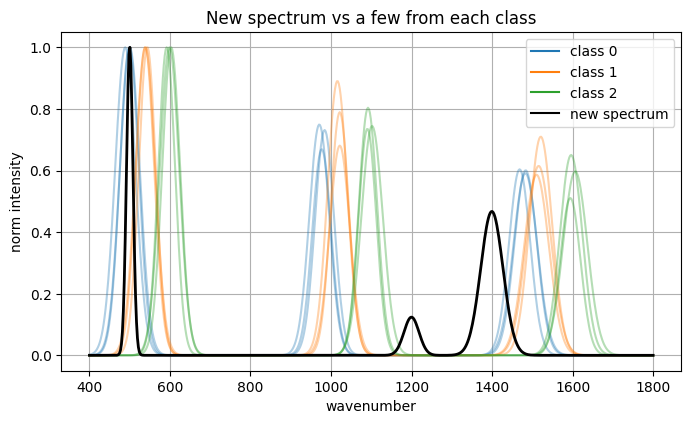

Encoded new spectrum (first 8 dims): [ 0.4584  0.3636  0.078  -0.1559 -0.1334 -0.4547 -0.3357 -0.2243]


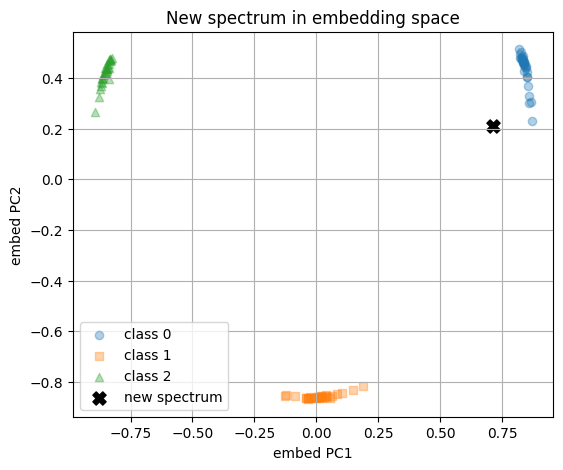

Predicted class: 0
Class probabilities: [0.883, 0.105, 0.012]
Nearest neighbor index in existing set: 6
Nearest neighbor label: 0
Cosine similarity in embedding space: 0.8453


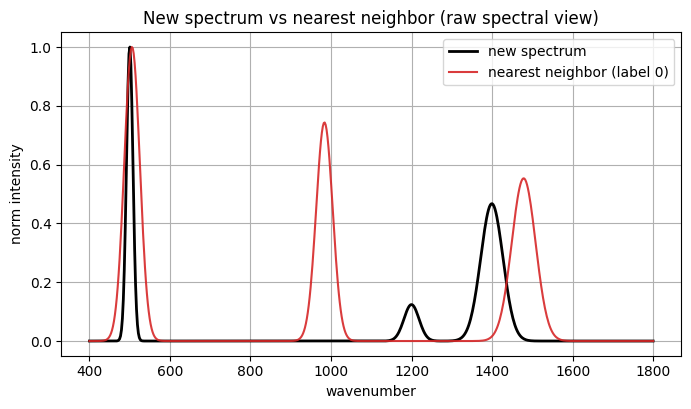

In [39]:
# === New spectrum: create, plot, encode, classify, compare (single cell) ===

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize as l2norm

# --- Compat layer: encode with sklearn .transform OR a PyTorch module (callable) ---
def encode_any(enc, X_np):
    """
    Encode a numpy array X_np with either:
      - sklearn-like encoder exposing .transform
      - torch.nn.Module (callable; returns a tensor)
    Returns numpy array of embeddings.
    """
    if hasattr(enc, "transform"):
        return enc.transform(X_np)
    try:
        import torch
        enc.eval()
        with torch.no_grad():
            Xt = torch.from_numpy(X_np.astype("float32"))
            Zt = enc(Xt)
            return Zt.cpu().numpy()
    except Exception as e:
        raise TypeError("Unsupported encoder type; expected sklearn-like or torch.nn.Module") from e

# --- Ensure the 2D projector exists; reuse prior basis if available, else fit on Z ---
try:
    pca2
except NameError:
    pca2 = PCA(n_components=2, random_state=0).fit(Z)

# --- Helper to synthesize a new spectrum with specified centers (small jitter) ---
def make_new_spectrum(x, centers, sigs=(1, 20, 28), amps=(1.0, 0.05, 0.6), jitter=1.0):
    peaks = []
    for mu, sig, amp in zip(centers, sigs, amps):
        mu_j = mu + rng.normal(0.0, jitter)
        sig_j = max(8.0, sig + rng.normal(0.0, 2.0))
        amp_j = max(0.2, amp + rng.normal(0.0, 0.26))
        peaks.append((mu_j, sig_j, amp_j))
    y = np.zeros_like(x, dtype=float)
    for (mu, sig, amp) in peaks:
        y += amp * np.exp(-0.5 * ((x - mu) / sig) ** 2)
    return y

# --- 1) New spectrum (different centers), mildly between class 1 and 2 ---
new_centers = [500, 1200, 1400]
spec_new_raw = make_new_spectrum(x, new_centers)
spec_new = normalize_minmax(spec_new_raw)

# --- 2) Plot new spectrum against a few samples from each class ---
plt.figure(figsize=(8, 4.4))
colors = ["tab:blue", "tab:orange", "tab:green"]
for cls, color in zip(range(3), colors):
    idx = np.where(labels == cls)[0][:3]
    for i in idx:
        plt.plot(x, normalize_minmax(spectra[i]), alpha=0.35, color=color)
plt.plot(x, spec_new, color="black", linewidth=2.0, label="new spectrum")
handles = [plt.Line2D([0],[0], color=c, label=f"class {k}") for k, c in zip(range(3), colors)]
handles.append(plt.Line2D([0],[0], color="black", label="new spectrum"))
plt.legend(handles=handles, loc="upper right")
plt.xlabel("wavenumber"); plt.ylabel("norm intensity")
plt.title("New spectrum vs a few from each class")
plt.show()

# --- 3) Encode the new spectrum with the existing encoder ---
z_new = encode_any(enc, spec_new.reshape(1, -1))[0]  # same dimensionality as rows of Z
print("Encoded new spectrum (first 8 dims):", np.round(z_new[:8], 4))

# Project into the same 2D embedding basis
P_all = pca2.transform(Z)
p_new = pca2.transform(z_new.reshape(1, -1))

plt.figure(figsize=(6.2, 5.0))
for cls, marker in zip(range(3), ["o", "s", "^"]):
    idx = np.where(labels == cls)[0]
    plt.scatter(P_all[idx, 0], P_all[idx, 1], alpha=0.35, marker=marker, label=f"class {cls}")
plt.scatter(p_new[0, 0], p_new[0, 1], c="black", s=90, marker="X", label="new spectrum")
plt.xlabel("embed PC1"); plt.ylabel("embed PC2")
plt.title("New spectrum in embedding space")
plt.legend()
plt.show()

# --- 4) Classify the new embedding with the existing linear probe ---
z_new_s = sc.transform(z_new.reshape(1, -1))
pred_class = clf.predict(z_new_s)[0]
proba_all = clf.predict_proba(z_new_s)[0]
print("Predicted class:", int(pred_class))
print("Class probabilities:", np.round(proba_all, 3).tolist())

# --- 5) Compare to nearest neighbor in the original set (cosine in embedding space) ---
Zn = l2norm(Z, axis=1)
zn_new = l2norm(z_new.reshape(1, -1), axis=1)
sims = (Zn @ zn_new.T).ravel()
nn_idx = int(np.argmax(sims))
print("Nearest neighbor index in existing set:", nn_idx)
print("Nearest neighbor label:", int(labels[nn_idx]))
print("Cosine similarity in embedding space:", round(float(sims[nn_idx]), 4))

# Optional: raw spectral comparison with nearest neighbor
plt.figure(figsize=(8, 4.2))
plt.plot(x, spec_new, color="black", linewidth=2.0, label="new spectrum")
plt.plot(x, normalize_minmax(spectra[nn_idx]), color="tab:red", alpha=0.9,
         label=f"nearest neighbor (label {int(labels[nn_idx])})")
plt.xlabel("wavenumber"); plt.ylabel("norm intensity")
plt.title("New spectrum vs nearest neighbor (raw spectral view)")
plt.legend()
plt.show()

---
### 8. Glossary

```{glossary}
Contrastive learning
  A method that trains an embedding so that two views of the same item are close and different items are far.

Positive pair
  Two augmented views of the same sample. They should remain close in the embedding.

Negative pair
  Two views from different samples. They should be far in the embedding.

Cosine similarity
  The dot product of normalized vectors. It measures alignment of directions.

Temperature
  A positive scalar in softmax that controls smoothness. Smaller values make distributions peakier.

InfoNCE loss
  A loss that maximizes agreement of the correct pair while contrasting against other items in the batch.

Linear probe
  A simple classifier trained on frozen embeddings to check if information is linearly recoverable.

Augmentation
  A transformation that preserves identity while adding variation such as noise or small jitters.

View
  The result of applying an augmentation to a sample. Two views of the same sample form a positive pair.

Retrieval
  Given a query in embedding space, return nearest neighbors by a similarity such as cosine.
```